# Traffic Sign Classification with a CNN

The dataset was taken from this source:
    http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html

The data was split into train and test folders. According to the source, there are 58 unique categories with varying counts for each category.

Imports and Configs

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import convert_to_tensor
from tensorflow.image import resize_with_pad
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import os, pathlib
from contextlib import ExitStack


sns.set_theme()

**Note: According to multiple sources, there's a bug with numpy and tensorflow resulting in an 'ImplementError' from some function calls. Downgrading to the versions below should fix the problem**

In [2]:
print(f'Numpy version: {np.version.version}')
print(f'Tensorflow version: {tf.__version__}')

Numpy version: 1.19.0
Tensorflow version: 2.3.0


The dataset wasn't split in directories to represent a class/category. Instead, the first three digits of the filenames indicates the class. The digits following the underscore represent a unique image for that particular traffic sign. E.g.:

    000_0001.png = Category 0, Image 1

Sometimes, the images are further subdivided to represent the same sign viewed from different angles. E.g.:

    000_1_0001 = Category 1, Image 1, Angle 1

To represent this, below is a list of the first 10 image names of the first image of each category/angle.

In [3]:
train_dir = pathlib.Path('data/tsrd-train')
signs = list(train_dir.glob('*_0001*'))
[f.name for f in signs[0:10]]

['000_0001.png',
 '000_1_0001.png',
 '001_0001.png',
 '001_1_0001.png',
 '002_0001.png',
 '002_1_0001.png',
 '003_0001.png',
 '003_1_0001.png',
 '004_0001.png',
 '004_1_0001.png']

The classes must first be clearly defined. To do this, pandas can be used to create a dataframe with a list of the image names in one colulmn and the labels in another.

In [4]:
# Labels
signs = [f.name for f in list(train_dir.glob('*.png'))] # Grab all file names
signs_classes = [f[0:3] for f in signs] # Grab first 3 numbers (class indicator)
signs_classes_unique = np.unique(signs_classes)
signs_classes_unique

array(['000', '001', '002', '003', '004', '005', '006', '007', '008',
       '009', '010', '011', '012', '013', '014', '015', '016', '017',
       '018', '019', '020', '021', '022', '023', '024', '025', '026',
       '027', '028', '029', '030', '031', '032', '033', '034', '035',
       '036', '037', '038', '039', '040', '041', '042', '043', '044',
       '045', '046', '047', '048', '049', '050', '051', '052', '053',
       '054', '055', '056', '057'], dtype='<U3')

In [5]:
# To replace dictionary for df.replace
to_replace = dict(zip(signs_classes_unique, signs_classes_unique.astype('int')))

In [6]:
df = {'File Names': signs, 'Labels': signs_classes}
df = pd.DataFrame(df)
df['Labels'] = df['Labels'].replace(to_replace=to_replace)
df['Labels'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57], dtype=int64)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4170 entries, 0 to 4169
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File Names  4170 non-null   object
 1   Labels      4170 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 65.3+ KB


## Class Distribution

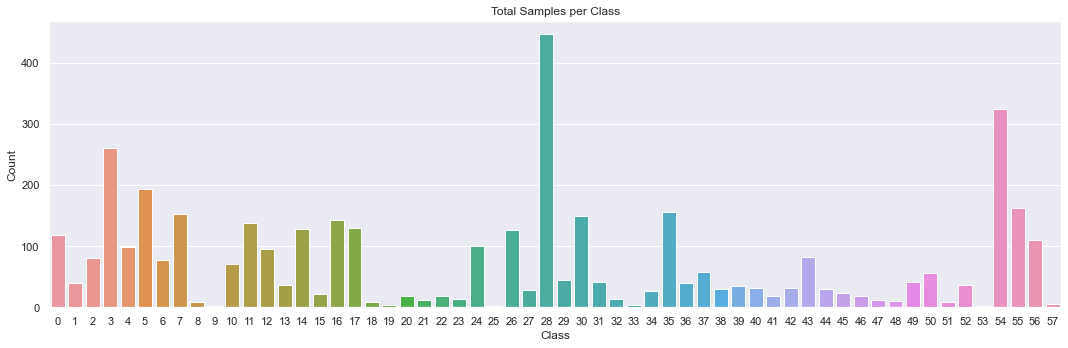

In [8]:
data = df['Labels'].value_counts().sort_index()
fig, ax = plt.subplots(1,1)
sns.barplot(x=data.index, y=data)
ax.set(
    ylabel='Count',
    xlabel='Class',
    title='Total Samples per Class'
)
fig.set(
    figheight=5,
    figwidth=15
)

fig.tight_layout()

## Top and Bottom 5 Images

In [9]:
data = df['Labels'].value_counts()
top5_idx = data[0:5].index
bottom5_idx = data[-5:len(data)].index

top5_fnames = []
bottom5_fnames = []
for cat in top5_idx:
    fname = df[df['Labels'] == cat].iloc[0, 0]
    top5_fnames.append(fname)

for cat in bottom5_idx:
    fname = df[df['Labels'] == cat].iloc[0, 0]
    bottom5_fnames.append(fname)

print(top5_fnames)
print(bottom5_fnames)

['028_0001.png', '054_0001.png', '003_0001.png', '005_0001.png', '055_0001.png']
['019_0001.png', '033_0001.png', '053_0001.png', '009_0001.png', '025_0001.png']


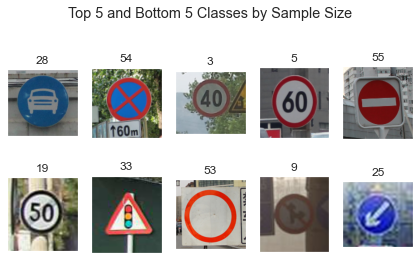

In [10]:
fig, ax = plt.subplots(2, 5)
ax = ax.ravel()

for idx, fname in enumerate(top5_fnames):
    img_dir = os.path.join(train_dir, fname)
    with Image.open(img_dir) as img:
        ax[idx].imshow(img)
    ax[idx].set(
        title=top5_idx[idx],
        xticks=[],
        yticks=[]
    )

for idx, fname in enumerate(bottom5_fnames):
    img_dir = os.path.join(train_dir, fname)
    with Image.open(img_dir) as img:
        ax[idx+5].imshow(img)
    ax[idx+5].set(
        title=bottom5_idx[idx-5],
        xticks=[],
        yticks=[]
    )

fig.suptitle('Top 5 and Bottom 5 Classes by Sample Size')
fig.tight_layout()

## Classes with sample size < 50

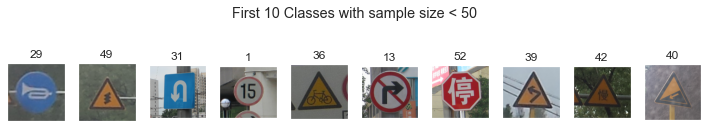

In [11]:
filter = df['Labels'].value_counts() <= 50
under_50 = df['Labels'].value_counts()[filter]

fig, ax = plt.subplots(1, 10)
ax = ax.ravel()
for i, idx in enumerate(under_50.index[0:10]):
    with Image.open(os.path.join(train_dir, df[df['Labels']==idx].iloc[0, 0])) as img:
        ax[i].imshow(img)
    ax[i].set(
        title=idx,
        xticks=[],
        yticks=[]
    )

fig.suptitle('First 10 Classes with sample size < 50', y=0.7)
fig.set(
    figheight=5,
    figwidth=10
)
fig.tight_layout()

## Viewing the provided testing dataset

Unique Classes

In [12]:
test_dir = pathlib.Path('data/tsrd-test')
signs = [f.name for f in list(test_dir.glob('*.png'))] # Grab all file names
signs_classes = [f[0:3] for f in signs] # Grab first 3 numbers (class indicator)
signs_classes_unique = np.unique(signs_classes)
signs_classes_unique

array(['000', '001', '002', '003', '004', '005', '006', '007', '008',
       '010', '011', '012', '013', '014', '015', '016', '017', '020',
       '021', '022', '023', '024', '025', '026', '027', '028', '029',
       '030', '031', '032', '034', '035', '036', '037', '038', '039',
       '040', '041', '042', '043', '044', '045', '046', '047', '048',
       '049', '050', '051', '052', '053', '054', '055', '056', '057'],
      dtype='<U3')

In [13]:
missing_classes = [x for x in list(range(58)) if x not in signs_classes_unique.astype('int')]
print(f'Missing Classes: {missing_classes}')

Missing Classes: [9, 18, 19, 33]


The missing classes are also in the list of classes with the lowest sample sizes. These classes will then be dropped during preprocessing. Furthermore, samplesizes less than 50 are much too low for any significant learning, so these classes will be dropped as well.

Creating pandas dataframes to use as indices

In [14]:
df_train = df.copy()

df_test = {'File Names': signs, 'Labels': signs_classes}
df_test = pd.DataFrame(df_test)
df_test['Labels'] = df_test['Labels'].replace(to_replace=to_replace)

classes_to_drop = np.unique(np.append(under_50.index.to_numpy(), missing_classes))
to_drop_train = df_train[df_train['Labels'].isin(classes_to_drop)].index
to_drop_test = df_test[df_test['Labels'].isin(classes_to_drop)].index
df_train.drop(index=to_drop_train, inplace=True)
df_test.drop(index=to_drop_test, inplace=True)

## Verifying the data

Text(0.5, 0.98, 'Verifying Image Labels')

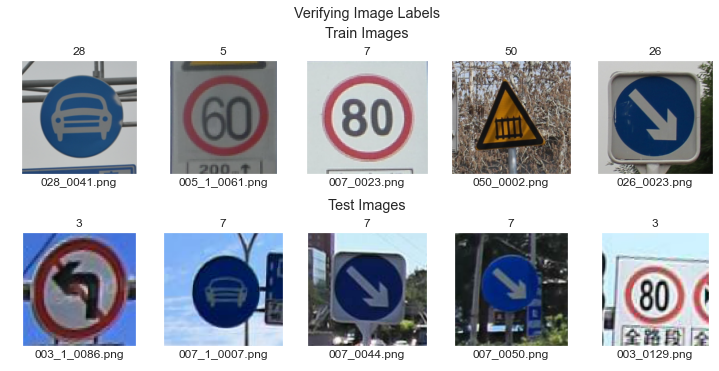

In [15]:
random_train_idx = np.random.randint(low=0, high=len(df_train), size=5)
random_test_idx = np.random.randint(low=0, high=len(df_test), size=5)

fig = plt.figure(constrained_layout=True)
fig.suptitle('Verifying Labels')

subfigs = fig.subfigures(2)

ax = subfigs[0].subplots(1, 5)
for idx, img_idx in enumerate(random_train_idx):
    img_fname = df_train['File Names'].iloc[img_idx]
    img_label = df_train['Labels'].iloc[img_idx]
    with Image.open(os.path.join(train_dir, img_fname)) as img:
        ax[idx].imshow(img)
    ax[idx].set(
        xticks=[],
        yticks=[],
        title=img_label,
        xlabel=img_fname
    )

ax = subfigs[1].subplots(1, 5)
for idx, img_idx in enumerate(random_test_idx):
    img_fname = df_train['File Names'].iloc[img_idx]
    img_label = df_train['Labels'].iloc[img_idx]
    with Image.open(os.path.join(test_dir, df_test['File Names'].iloc[img_idx])) as img:
        ax[idx].imshow(img)
    ax[idx].set(
        xticks=[],
        yticks=[],
        title=img_label,
        xlabel=img_fname
    )

subfigs[0].suptitle('Train Images')
subfigs[1].suptitle('Test Images')

fig.set(
    figwidth=10,
    figheight=5,
)
fig.suptitle('Verifying Image Labels')

# Preprocessing

In [16]:
train_dir = 'data/tsrd-train'
test_dir = 'data/tsrd-test'

# Using the dataframe makes it possible to easily load only the desired images instead of loading
# the entire directory and filtering again.
train_fnames = [os.path.join(train_dir, fname) for fname in df_train['File Names']]
test_fnames = [os.path.join(test_dir, fname) for fname in df_test['File Names']]

# Loading image files using a context manager
with ExitStack() as stack:
    train_imgs = [stack.enter_context(Image.open(fname)) for fname in train_fnames]
    test_imgs = [stack.enter_context(Image.open(fname)) for fname in test_fnames]

    # Converting images to array format using tensorflow's image processing utils
    train_imgs = [image.img_to_array(img) for img in train_imgs]
    test_imgs = [image.img_to_array(img) for img in test_imgs]

## Homogenizing Image Sizes

CNNs can't accept images with different sizes. CNNs are fitted on a flattened image (1D Array) of a certain size, meaning it can't be fitted on other images of different sizes. The images in this dataset all have different sizes. Considering this, the images will be resized to close to the average height and width with padding to not distort the image.

In [17]:
widths, heights = [img.shape[1] for img in train_imgs], [img.shape[0] for img in train_imgs]
width_mean, height_mean = sum(widths)/len(widths), sum(heights)/len(heights)
print(f'Average width: {width_mean}, Average height: {height_mean}')

Average width: 153.5112912565142, Average height: 142.0816444701795


In [18]:
train_imgs = convert_to_tensor([resize_with_pad(img, 150, 150) for img in train_imgs])
test_imgs = convert_to_tensor([resize_with_pad(img, 150, 150) for img in test_imgs])
print(train_imgs.shape, test_imgs.shape)

(3454, 150, 150, 3) (1474, 150, 150, 3)


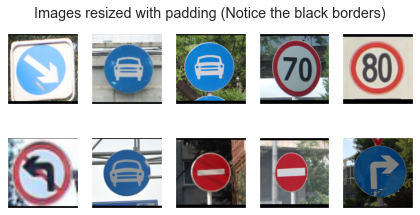

In [19]:
random_idx = np.random.randint(low=0, high=len(train_imgs), size=10)

fig, ax = plt.subplots(2, 5)
ax = np.ravel(ax)

for idx, img_idx in enumerate(random_idx):
    ax[idx].imshow(image.array_to_img(train_imgs[img_idx]))
    ax[idx].set(
        xticks=[],
        yticks=[]
    )
fig.suptitle('Images resized with padding (Notice the black borders)', y=0.85)
fig.tight_layout()

## Merging image data and labels

pd.get_dummies works by order of the first thing it is given, meaning it won't automatically order the one-hot labels by number. However, since the two dataframes have the exact same classes present in the same order, this shouldn't be a problem. Nevertheless, the two arrays will be compared element-wise and return an exception if they aren't exactly the same.

The index of the one-hot encoded labels is also printed below, this will be useful when assigning class weights. Assigning class weights is a necessary steps considering how imbalanced the dataset is.

In [20]:
train_labels = pd.get_dummies(df_train['Labels'])
test_labels = pd.get_dummies(df_test['Labels'])

if not (train_labels.columns == test_labels.columns).all():
    raise Exception('Train and Test one-hot encoded labels are not indexed the same.')

print(f'Index of one-hot encoded labels: \n {train_labels.columns}')

Index of one-hot encoded labels: 
 Int64Index([ 0,  2,  3,  4,  5,  6,  7, 10, 11, 12, 14, 16, 17, 24, 26, 28, 30,
            35, 37, 43, 50, 54, 55, 56],
           dtype='int64')


In [21]:
datagen = ImageDataGenerator()

train_iterator = datagen.flow(train_imgs, train_labels, batch_size=128, seed=42)
test_iterator = datagen.flow(test_imgs, test_labels, batch_size=128, seed=42)

# Creating the model

## Data Standardization
CNN's work better with constrained values, so the image's RGB values will be limited to a [0,1] range.

        Source:
        https://www.tensorflow.org/tutorials/images/classification

Fortunately, with tensorflow's api, this can be done within the model itself.

In [22]:
standardize = layers.experimental.preprocessing.Rescaling(1./255)

## The Model

The model will consist of various convolutional layers coupled with max-pooling layers. The convolutional layers allow the network to learn the various features of an image while the max-pooling layer reduces noise and helps with overfitting. The number of neurons can be arbitrarily choesn. Other arguments use the defaults.


Finally, the model was structured based on two sources: the source above and another one below:

    https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

In [23]:
num_classes = df_train['Labels'].nunique()

batchX, batchy = train_iterator.next()
model = Sequential([
    layers.InputLayer(input_shape=(150, 150, 3)),
    standardize,
    layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), padding='same', activation='relu'),
    layers.MaxPool2D(strides=2),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPool2D(strides=2),
    layers.Conv2D(128, (9, 9), activation='relu'),
    layers.MaxPool2D(strides=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

Compiling the Model and Model Summary

In [24]:
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics='categorical_accuracy'
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       663680    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0

### Base Accuracy

In [25]:
base_accuracy = df_train['Labels'].value_counts(normalize=True).iloc[0]
base_accuracy

0.12912565141864504

### Defining class weights by simple percentage

As demonstrated in the class distribution graph, the dataset is imbalanced and hence class weights have to be assigned. Class weights can be manually assigned but, for this project, the following formula will be used:

    weight = n_samples / (n_classes * n_samples_class)

    n_samples = total length of dataset
    n_classes = number of unique classes
    n_samples_class = total samples of that class

    Source: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

As the labels are sorted in ascending order as shown previously, the weights can be similarly indexed.

In [26]:
weight = lambda n_samples, n_classes, n_samples_class:\
    n_samples/(n_classes*n_samples_class)

counts = df_train['Labels'].value_counts().sort_index(ascending=True)

n_samples, n_classes = len(df_train), len(counts)
weights = []
for count in counts:
    n_samples_class = count
    weights.append(weight(n_samples, n_classes, n_samples_class))

weights = dict(zip(list(range(n_classes)), weights))

Training

In [27]:
early_stopping = EarlyStopping(patience=5)
history = model.fit(
    train_iterator,
    validation_data = test_iterator,
    epochs=10,
    class_weight=weights,
    callbacks=[early_stopping]
)

Epoch 1/10
27/27 [==============================] - 61s 2s/step - loss: 3.0323 - categorical_accuracy: 0.0958 - val_loss: 2.6193 - val_categorical_accuracy: 0.1872
Epoch 2/10
27/27 [==============================] - 59s 2s/step - loss: 1.3338 - categorical_accuracy: 0.5866 - val_loss: 1.8517 - val_categorical_accuracy: 0.5495
Epoch 3/10
27/27 [==============================] - 60s 2s/step - loss: 0.3821 - categorical_accuracy: 0.8819 - val_loss: 1.7812 - val_categorical_accuracy: 0.5957
Epoch 4/10
27/27 [==============================] - 59s 2s/step - loss: 0.1649 - categorical_accuracy: 0.9424 - val_loss: 2.2166 - val_categorical_accuracy: 0.6404
Epoch 5/10
27/27 [==============================] - 62s 2s/step - loss: 0.0596 - categorical_accuracy: 0.9809 - val_loss: 1.5683 - val_categorical_accuracy: 0.6757
Epoch 6/10
27/27 [==============================] - 61s 2s/step - loss: 0.0511 - categorical_accuracy: 0.9847 - val_loss: 2.1548 - val_categorical_accuracy: 0.6323
Epoch 7/10
27/27

## Metrics

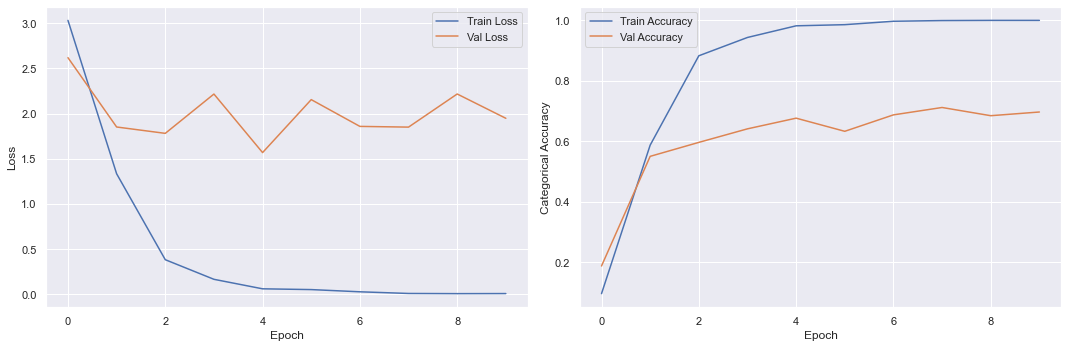

In [28]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(history.epoch, history.history['loss'], label='Train Loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='Val Loss')
ax[0].set(
    xlabel='Epoch',
    ylabel='Loss'
)
ax[0].legend()

ax[1].plot(history.epoch, history.history['categorical_accuracy'], label='Train Accuracy')
ax[1].plot(history.epoch, history.history['val_categorical_accuracy'], label='Val Accuracy')
ax[1].set(
    xlabel='Epoch',
    ylabel='Categorical Accuracy'
)
ax[1].legend()

fig.set(
    figwidth=15,
    figheight=5
)
fig.tight_layout()